# Timeseries

This whole notebook is taken from [*Modern Pandas (Part 7)*](https://tomaugspurger.github.io/) by Tom Augspurger (Anaconda, Inc). Just added one import for pandas_datareader in order to grab some data from yahoo finance.

[https://github.com/TomAugspurger](https://github.com/TomAugspurger)

[https://www.linkedin.com/in/tom-augspurger-01269315/](https://www.linkedin.com/in/tom-augspurger-01269315/)

[https://twitter.com/tomaugspurger](https://twitter.com/tomaugspurger)

## Timeseries

Pandas started out in the financial world, so naturally it has strong timeseries support.

The first half of this post will look at pandas' capabilities for manipulating time series data. The second half will discuss modelling time series data with statsmodels.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")  # ignore 'FutureWarning: Panel is deprecated and will be removed in a future version.'
import numpy as np  # 1.14.3
import pandas as pd  # 0.23.0

pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as pdr  # pip install pandas_datareader==0.6.0
import fix_yahoo_finance as yf  # pip install fix_yahoo_finance==0.0.21
yf.pdr_override()

import seaborn as sns  # 0.8.1
import matplotlib.pyplot as plt  # 2.2.2
sns.set(style='ticks', context='talk')

Let's grab some stock data for Goldman Sachs using the [pandas-datareader](http://pandas-datareader.readthedocs.io/en/latest/) package, which spun off of pandas:

In [2]:
gs = pdr.get_data_yahoo("GS", start="2006-01-01", end="2010-01-01")
gs.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,111.672585,6188700
2006-01-04,127.349998,128.910004,126.379997,127.089996,110.130142,4861600
2006-01-05,126.000000,127.320000,125.610001,127.040001,110.086807,3717400
2006-01-06,127.290001,129.250000,127.290001,128.839996,111.646584,4319600
2006-01-09,128.500000,130.619995,128.000000,130.389999,112.989769,4723500


There isn't a special data-container just for time series in pandas, they're just `Series` or `DataFrames` with a `DatetimeIndex`.

## Special Slicing

Looking at the elements of `gs.index`, we see that `DatetimeIndex`es are made up of `pandas.Timestamp`s:

In [3]:
gs.index[0]

Timestamp('2006-01-03 00:00:00')

A `Timestamp` is mostly compatible with the `datetime.datetime` class, but much amenable to storage in arrays.

Working with `Timestamp`s can be awkward, so Series and DataFrames with `DatetimeIndex`es have some special slicing rules. The first special case is *partial-string indexing*. Say we wanted to select all the days in 2006. Even with `Timestamp`'s convenient constructors, it's a pain:

In [4]:
gs.loc[pd.Timestamp('2006-01-01'):pd.Timestamp('2006-12-31')].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,111.672585,6188700
2006-01-04,127.349998,128.910004,126.379997,127.089996,110.130142,4861600
2006-01-05,126.000000,127.320000,125.610001,127.040001,110.086807,3717400
2006-01-06,127.290001,129.250000,127.290001,128.839996,111.646584,4319600
2006-01-09,128.500000,130.619995,128.000000,130.389999,112.989769,4723500


Thanks to partial-string indexing, it's as simple as:

In [5]:
gs.loc['2006'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,111.672585,6188700
2006-01-04,127.349998,128.910004,126.379997,127.089996,110.130142,4861600
2006-01-05,126.000000,127.320000,125.610001,127.040001,110.086807,3717400
2006-01-06,127.290001,129.250000,127.290001,128.839996,111.646584,4319600
2006-01-09,128.500000,130.619995,128.000000,130.389999,112.989769,4723500


Since label slicing is inclusive, this slice selects any observation where the year is 2006.

The second "convenience" is `__getitem__` (square-bracket) fall-back indexing. I'm only going to mention it here, with the caveat that you should never use it. DataFrame `__getitem__` typically looks in the column: `gs['2006']` would search `gs.columns` for `'2006'`, not find it, and raise a `KeyError`. But DataFrames with a `DatetimeIndex` catch that `KeyError` and try to slice the index. If it succeeds in slicing the index, the result like `gs.loc['2006']` is returned. If it fails, the `KeyError` is re-raised. This is confusing because in pretty much every other case `DataFrame.__getitem__` works on columns, and it's fragile because if you happened to have a column `'2006'` you would get just that column, and no fall-back indexing would occur. Just use `gs.loc['2006']` when slicing DataFrame indexes.

## Special Methods

### Resampling

Resampling is similar to a `groupby`: you split the time series into groups (5-day buckets below), apply a function to each group (`mean`), and combine the result (one row per group).

In [6]:
gs.resample("5d").mean().head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,126.834999,128.730002,125.877501,127.959997,110.884030,4.771825e+06
2006-01-08,130.349998,132.645000,130.205002,131.660000,114.090290,4.664300e+06
2006-01-13,131.510002,133.395005,131.244995,132.924995,115.186458,3.258250e+06
2006-01-18,132.210002,133.853333,131.656667,132.543335,114.926798,4.997767e+06
2006-01-23,133.771997,136.083997,133.310001,135.153998,117.337241,3.968500e+06


In [7]:
gs.resample("W").agg(['mean', 'sum']).head()

Open                    High                     Low  \
                  mean         sum        mean         sum        mean   
Date                                                                     
2006-01-08  126.834999  507.339996  128.730002  514.920006  125.877501   
2006-01-15  130.684000  653.419998  132.848001  664.240006  130.544000   
2006-01-22  131.907501  527.630005  133.672501  534.690003  131.389999   
2006-01-29  133.771997  668.859986  136.083997  680.419983  133.310001   
2006-02-05  140.900000  704.500000  142.467999  712.339996  139.937998   

                             Close               Adj Close              \
                   sum        mean         sum        mean         sum   
Date                                                                     
2006-01-08  503.510002  127.959997  511.839988  110.884030  443.536118   
2006-01-15  652.720001  131.979999  659.899994  114.367583  571.837913   
2006-01-22  525.559998  132.555000  530.220000  114.919140  459.676559   
2006-01-29  666.550003  135.153998  675.769989  117.337241  586.686203   
2006-02-05  699.689988  141.618002  708.090011  122.949094  614.745468   

               Volume            
                 mean       sum  
Date                             
2006-01-08  4771825.0  19087300  
2006-01-15  4310420.0  21552100  
2006-01-22  4653725.0  18614900  
2006-01-29  3968500.0  19842500  
2006-02-05  3920120.0  19600600

You can up-sample to convert to a higher frequency. The new points are filled with NaNs.

In [8]:
gs.resample("6H").mean().head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03 00:00:00,126.699997,129.440002,124.230003,128.869995,111.672585,6188700.0
2006-01-03 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04 00:00:00,127.349998,128.910004,126.379997,127.089996,110.130142,4861600.0


### Rolling / Expanding / EW

These methods aren't unique to `DatetimeIndex`es, but they often make sense with time series, so I'll show them here.

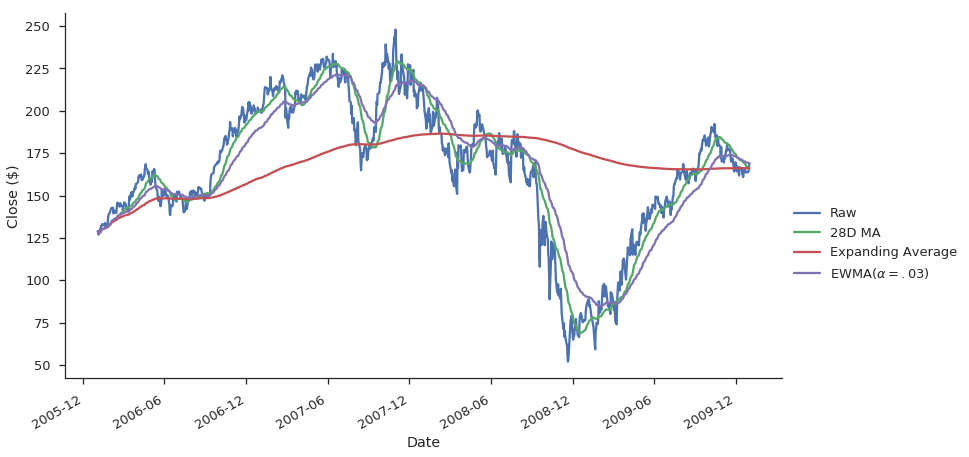

In [60]:
gs.Close.plot(label='Raw', figsize=(10, 5))
gs.Close.rolling(28).mean().plot(label='28D MA')
gs.Close.expanding().mean().plot(label='Expanding Average')
gs.Close.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

plt.legend(bbox_to_anchor=(1.0, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
fig = plt.gcf()
fig.set_size_inches(15, 7)

Each of `.rolling`, `.expanding`, and `.ewm` return a deferred object, similar to a GroupBy.

In [62]:
roll = gs.Close.rolling(30, center=True)
roll

Rolling [window=30,center=True,axis=0]

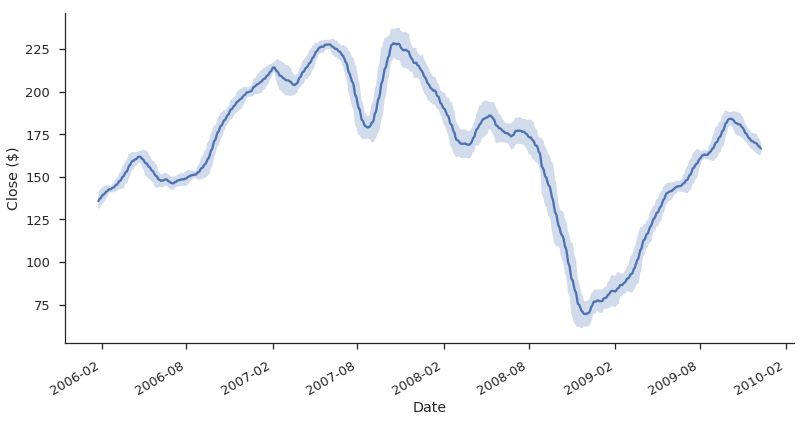

In [65]:
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot()
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()
fig = plt.gcf()
fig.set_size_inches(12, 7)

## Grab Bag

### Offsets

These are similar to `dateutil.relativedelta`, but works with arrays.

In [68]:
gs.index

DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2009-12-17', '2009-12-18', '2009-12-21', '2009-12-22',
               '2009-12-23', '2009-12-24', '2009-12-28', '2009-12-29',
               '2009-12-30', '2009-12-31'],
              dtype='datetime64[ns]', name='Date', length=1007, freq=None)

In [67]:
gs.index + pd.DateOffset(months=3, days=-2)

DatetimeIndex(['2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-07', '2006-04-08', '2006-04-09', '2006-04-10',
               '2006-04-11', '2006-04-15',
               ...
               '2010-03-15', '2010-03-16', '2010-03-19', '2010-03-20',
               '2010-03-21', '2010-03-22', '2010-03-26', '2010-03-27',
               '2010-03-28', '2010-03-29'],
              dtype='datetime64[ns]', name='Date', length=1007, freq=None)

### Holiday Calendars

There are a whole bunch of special calendars, useful for traders probabaly.

In [70]:
from pandas.tseries.holiday import USColumbusDay
USColumbusDay.dates('2015-01-01', '2020-01-01')

DatetimeIndex(['2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08',
               '2019-10-14'],
              dtype='datetime64[ns]', freq='WOM-2MON')

### Timezones

Pandas works with `pytz` for nice timezone-aware datetimes. The typical workflow is:

1. localize timezone-naive timestamps to some timezone
2. convert to desired timezone

If you already have timezone-aware Timestamps, there's no need for step one. 

In [71]:
# tz naive -> tz aware..... to desired UTC
gs.tz_localize('US/Eastern').tz_convert('UTC').head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03 05:00:00+00:00,126.699997,129.440002,124.230003,128.869995,111.672585,6188700
2006-01-04 05:00:00+00:00,127.349998,128.910004,126.379997,127.089996,110.130142,4861600
2006-01-05 05:00:00+00:00,126.000000,127.320000,125.610001,127.040001,110.086807,3717400
2006-01-06 05:00:00+00:00,127.290001,129.250000,127.290001,128.839996,111.646584,4319600
2006-01-09 05:00:00+00:00,128.500000,130.619995,128.000000,130.389999,112.989769,4723500


## Modeling Time Series

The rest of this post will focus on time series in the econometric sense. My indented reader for this section isn't all that clear, so I apologize upfront for any sudden shifts in complexity. I'm roughly targeting material that could be presented in a first or second semester applied statistics course. What follows certainly isn't a replacement for that. Any formality will be restricted to footnotes for the curious. I've put a whole bunch of resources at the end for people earger to learn more.

We'll focus on modelling Average Monthly Flights. Let's download the data. If you've been following along in the series, you've seen most of this code before, so feel free to skip.

In [73]:
import os
import io
import glob
import zipfile
from utils import download_timeseries

import statsmodels.api as sm


def download_many(start, end):
    months = pd.period_range(start, end=end, freq='M')
    # We could easily parallelize this loop.
    for i, month in enumerate(months):
        download_timeseries(month)


def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.

    2014-01-01,1149.0 -> 2014-01-01T11:49:00
    '''
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return  pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        return datetime_part
    df[columns] = df[columns].apply(converter)
    return df


def read_one(fp):
    df = (pd.read_csv(fp, encoding='latin1')
            .rename(columns=str.lower)
            .drop('unnamed: 6', axis=1)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time',
                                     'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date'])))
    return df


Here you need to create following directories: ./data and ./data/timeseries

In [76]:
store = './data/ts.hdf5'

if not os.path.exists(store):
    download_many('2000-01-01', '2016-01-01')

    zips = glob.glob(os.path.join('data', 'timeseries', '*.zip'))
    dfs = [read_one(fp) for fp in csvs]
    df = pd.concat(dfs, ignore_index=True)

    df['origin'] = df['origin'].astype('category')
    df.to_hdf(store, 'ts', format='table')
else:
    df = pd.read_hdf(store, 'ts')

NameError: name 'csvs' is not defined